[sub-170] epoch 005 train_recon=0.442851 test_recon=0.767834


KeyboardInterrupt: 

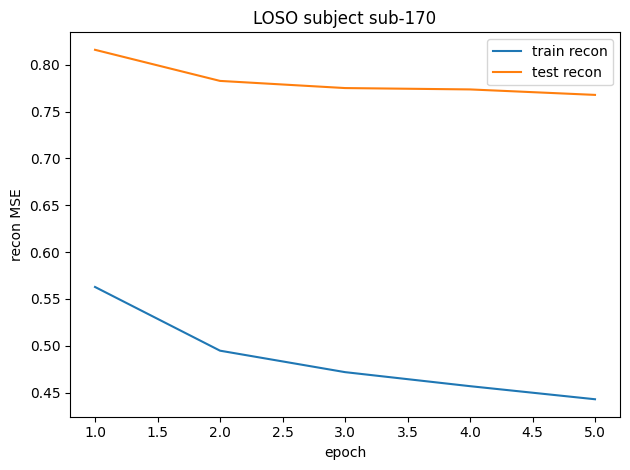

In [1]:
#!/usr/bin/env python3
import glob
import os
import re
import math
import time
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import xarray as xr


@dataclass(frozen=True)
class SegmentKey:
    subject: str
    run: str
    segment: str


def parse_segment_key(path: str) -> SegmentKey:
    """Extract (subject, run, segment) from a filename."""
    name = os.path.basename(path)
    pattern = r"(sub-[^_]+).*?run-([^_]+).*?_(\d+)(?:_test)?\.nc$"
    match = re.search(pattern, name)
    if not match:
        raise ValueError(f"Could not parse subject/run/segment from {name}")
    return SegmentKey(match.group(1), match.group(2), match.group(3))


def list_pairs(sparse_root: str, dense_root: str) -> list[tuple[str, str, SegmentKey]]:
    # Scan both roots and align by subject/run/segment keys.
    sparse_files = glob.glob(os.path.join(sparse_root, "**", "*.nc"), recursive=True)
    dense_files = glob.glob(os.path.join(dense_root, "**", "*.nc"), recursive=True)

    sparse_map = {parse_segment_key(f): f for f in sparse_files}
    dense_map = {parse_segment_key(f): f for f in dense_files}
    keys = sorted(set(sparse_map.keys()) & set(dense_map.keys()), key=lambda k: (k.subject, k.run, k.segment))
    pairs = [(sparse_map[k], dense_map[k], k) for k in keys]
    if not pairs:
        raise RuntimeError("No aligned sparse/dense pairs found. Check your paths and naming.")
    return pairs


class ParcelPairDataset(Dataset):
    def __init__(self, pairs: list[tuple[str, str, SegmentKey]], stats: dict | None = None):
        self.pairs = pairs
        self.stats = stats

        sample = xr.open_dataarray(pairs[0][0]).values
        if sample.ndim != 3:
            raise ValueError(f"Expected [parcel, chromo, time], got {sample.shape}")
        self.parcels, self.chromos, self.times = sample.shape

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int):
        sparse_path, dense_path, _ = self.pairs[idx]
        x = xr.open_dataarray(sparse_path).values.astype(np.float32)
        y = xr.open_dataarray(dense_path).values.astype(np.float32)

        if self.stats is not None:
            # Normalize using training-only statistics.
            x = (x - self.stats["x_mean"]) / self.stats["x_std"]
            y = (y - self.stats["y_mean"]) / self.stats["y_std"]
            x = x.astype(np.float32)
            y = y.astype(np.float32)

        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        return x, y


def compute_stats(pairs: list[tuple[str, str, SegmentKey]]) -> dict:
    # Streaming mean/std to avoid loading everything at once.
    start = time.time()
    x_sum = 0.0
    x_sumsq = 0.0
    x_count = 0
    y_sum = 0.0
    y_sumsq = 0.0
    y_count = 0
    for idx, (sparse_path, dense_path, _) in enumerate(pairs, start=1):
        x = xr.open_dataarray(sparse_path).values.astype(np.float64)
        y = xr.open_dataarray(dense_path).values.astype(np.float64)
        x_sum += x.sum()
        x_sumsq += (x * x).sum()
        x_count += x.size
        y_sum += y.sum()
        y_sumsq += (y * y).sum()
        y_count += y.size
        if idx % 50 == 0 or idx == len(pairs):
            elapsed = time.time() - start
            print(f"compute_stats: {idx}/{len(pairs)} files in {elapsed:.1f}s")
    x_mean = x_sum / x_count
    y_mean = y_sum / y_count
    x_var = max(x_sumsq / x_count - x_mean * x_mean, 1e-8)
    y_var = max(y_sumsq / y_count - y_mean * y_mean, 1e-8)
    return {
        "x_mean": x_mean,
        "x_std": np.sqrt(x_var),
        "y_mean": y_mean,
        "y_std": np.sqrt(y_var),
    }


class Conv2DVAE(nn.Module):
    """
    Conditional Variational Autoencoder.
    2D convolutions over (parcel, time) dimensions.
    Chromophores are treated as channels.
    3x3 kernels with padding.
    """
    def __init__(self, parcels: int, chromos: int, times: int, latent_dim: int, hidden_channels: int):
        super().__init__()
        self.parcels = parcels
        self.chromos = chromos
        self.times = times
        self.hidden_channels = hidden_channels

        # Encoder: 2D convs over (parcel, time) with chromo as channels.
        self.encoder = nn.Sequential(
            nn.Conv2d(chromos, hidden_channels, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
        )
        
        # Flattened size of the conv feature map for the linear latent heads.
        flat_dim = hidden_channels * parcels * times
        
        # Latent mean/logvar for reparameterization.
        self.mu = nn.Linear(flat_dim, latent_dim)
        self.logvar = nn.Linear(flat_dim, latent_dim)
        
        # Decoder: project z to feature map, condition on X, then conv to chromos.
        self.z_to_feat = nn.Linear(latent_dim, flat_dim)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_channels + chromos, hidden_channels, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, chromos, kernel_size=(3, 3), padding=1),
        )

    def encode(self, x_c: torch.Tensor):
        h = self.encoder(x_c)
        # Flatten conv features to feed the linear latent heads (mu/logvar).
        h_flat = h.view(h.size(0), -1)
        return self.mu(h_flat), self.logvar(h_flat)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor, x_c: torch.Tensor):
        feat = self.z_to_feat(z).view(-1, self.hidden_channels, self.parcels, self.times)
        feat = torch.cat([feat, x_c], dim=1)
        return self.decoder(feat)

    def forward(self, x: torch.Tensor):
        # x: [batch, parcel, chromo, time] -> [batch, chromo, parcel, time]
        x_c = x.permute(0, 2, 1, 3)
        mu, logvar = self.encode(x_c)
        z = self.reparameterize(mu, logvar)
        y_c = self.decode(z, x_c)
        
        # Return to [batch, parcel, chromo, time] to match targets.
        y = y_c.permute(0, 2, 1, 3)
        return y, mu, logvar


def vae_loss(recon: torch.Tensor, target: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor):
    recon_loss = F.mse_loss(recon, target, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl, recon_loss


def update_and_save_plot(fig, ax, train_line, test_line, train_curve, test_curve, epoch, out_path):
    train_line.set_data(range(1, epoch + 1), train_curve)
    test_line.set_data(range(1, epoch + 1), test_curve)
    ax.relim()
    ax.autoscale_view()
    fig.tight_layout()
    fig.savefig(out_path, dpi=150)


def create_grid_plot(subjects):
    n_sub = len(subjects)
    n_cols = min(3, n_sub)
    n_rows = math.ceil(n_sub / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), squeeze=False)
    axes_flat = axes.ravel()

    plot_items = {}
    for idx, subject in enumerate(subjects):
        ax = axes_flat[idx]
        train_line, = ax.plot([], [], label="train recon")
        test_line, = ax.plot([], [], label="test recon")
        ax.set_title(subject)
        ax.set_xlabel("epoch")
        ax.set_ylabel("recon MSE")
        ax.legend()
        plot_items[subject] = (ax, train_line, test_line)

    for idx in range(n_sub, len(axes_flat)):
        axes_flat[idx].axis("off")

    return fig, plot_items


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_recon = 0.0
    total_steps = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        recon, mu, logvar = model(x)
        loss, recon_loss = vae_loss(recon, y, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_recon += recon_loss.item()
        total_steps += 1
    return total_recon / max(total_steps, 1)


@torch.no_grad()
def eval_one_epoch(model, loader, device):
    model.eval()
    total_recon = 0.0
    total_steps = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        recon, mu, logvar = model(x)
        _, recon_loss = vae_loss(recon, y, mu, logvar)
        total_recon += recon_loss.item()
        total_steps += 1
    return total_recon / max(total_steps, 1)


def run_loso(pairs, epochs, batch_size, latent_dim, hidden_dim, lr, plot_dir):
    subjects = sorted({k.subject for _, _, k in pairs})
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(plot_dir, exist_ok=True)

    fig, plot_items = create_grid_plot(subjects)
    plot_path = os.path.join(plot_dir, "loso_grid.png")

    for test_subject in subjects:
        fold_start = time.time()
        train_pairs = [p for p in pairs if p[2].subject != test_subject]
        test_pairs = [p for p in pairs if p[2].subject == test_subject]
        
        # mean and std of training data
        stats = compute_stats(train_pairs)
        print(f"[{test_subject}] stats in {time.time() - fold_start:.1f}s")

        # Build datasets with training stats applied to both splits.
        ds_start = time.time()
        train_ds = ParcelPairDataset(train_pairs, stats=stats)
        test_ds = ParcelPairDataset(test_pairs, stats=stats)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        print(f"[{test_subject}] datasets+loaders in {time.time() - ds_start:.1f}s")

        model = Conv2DVAE(
            train_ds.parcels,
            train_ds.chromos,
            train_ds.times,
            latent_dim,
            hidden_dim,
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        ax, train_line, test_line = plot_items[test_subject]

        train_curve = []
        test_curve = []
        for epoch in range(1, epochs + 1):
            train_recon = train_one_epoch(model, train_loader, optimizer, device)
            test_recon = eval_one_epoch(model, test_loader, device)
            train_curve.append(train_recon)
            test_curve.append(test_recon)

            if epoch % 5 == 0 or epoch == epochs:
                print(
                    f"[{test_subject}] epoch {epoch:03d} "
                    f"train_recon={train_recon:.6f} test_recon={test_recon:.6f}"
                )
            if epoch % 5 == 0 or epoch == epochs:
                update_and_save_plot(
                    fig,
                    ax,
                    train_line,
                    test_line,
                    train_curve,
                    test_curve,
                    epoch,
                    plot_path,
                )

    plt.close(fig)


def main():
    sparse_root = "datasets/full_processed/BallSqueezingHD_modified"
    dense_root = "datasets/subset_2_processed/BallSqueezingHD_modified"
    
    epochs = 50
    batch_size = 8
    latent_dim = 64
    hidden_dim = 16
    lr = 1e-3
    plot_dir = "figures/parcel_cvae"

    pairs = list_pairs(sparse_root, dense_root)
    run_loso(
        pairs,
        epochs=epochs,
        batch_size=batch_size,
        latent_dim=latent_dim,
        hidden_dim=hidden_dim,
        lr=lr,
        plot_dir=plot_dir,
    )


if __name__ == "__main__":
    main()
